# Projet 7 - Implémentez un modèle de scoring : Notebook de la modélisation (du prétraitement à la prédiction)

#### A partir de diverses informations historiques sur des demandeurs de prêt, nous allons essayer de prédire pour un nouveau demandeur de prêt, sa faculté à rembourser le prêt qui lui sera accordé dans les temps (étiquette 0) ou son éventuelle défaillance (étiquette 1).
#### Les étiquettes des données étant incluses dans les données d'entraînement, nous sommes dans un cas de classification supervisée binaire.

## Présentation des données

Nous avons 7 sources de données différentes :

- application_train/application_test : les principales données de formation et de test contenant des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de la demande d'entraînement sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.

- bureau : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.

- bureau_balance : données mensuelles sur les crédits précédents dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

- previous_application : demandes antérieures de prêts de clients ayant des prêts dans les données de la demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique SK_ID_PREV.

- POS_CASH_BALANCE : données mensuelles sur les prêts au point de vente ou au comptant que les clients ont eus. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.

- credit_card_balance : données mensuelles concernant les cartes de crédit que les clients ont eues précédemment. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

- installments_payment : historique des paiements pour les prêts précédents. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

Toutes les variables des différentes tables sont définies dans la table HomeCredit_columns_description.csv et un exemple du fichier de soumission attendu est également fourni dans la table sample_submission.

Nous pouvons observé les différents liens entre les tables des données dans le schéma ci-dessous.

## Importation des données et analyses exploratoires

In [1]:
# Importation des librairies nécessaires 

import numpy as np # Pour la manipulation des données
import pandas as pd # Pour la manipulation des données

from sklearn.preprocessing import LabelEncoder # Pour le traitement des variables catégorielles

import matplotlib.pyplot as plt # Pour la visualisation
import seaborn as sns # Pour la visualisation

import os # Pour la gestion des fichiers
import re

import warnings # Pour ignorer certains alertes non bloquantes
warnings.filterwarnings('ignore')

In [2]:
warnings.simplefilter(category=UserWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

In [3]:
### Lecture des données

data = "./P7/" # Chemin pour l'ensemble des données
os.listdir(data)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [4]:
# Données d'entraînement
data_train = pd.read_csv('./P7/application_train.csv')
print('Training data shape: ', data_train.shape)
data_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
# Données de test
data_test = pd.read_csv('./P7/application_test.csv')
print('Testing data shape: ', data_test.shape)
data_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Nous remarquons que les données de test ne corportent pas la variable cible à prédire "TARGET"

## Analyses exploratoires des données

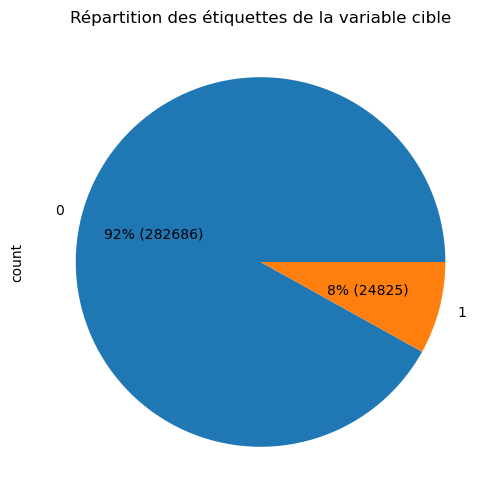

In [6]:
#Répartition des modalités de la variable cible dans les données d'entraînement

plt.figure(figsize=(8,6))
ax = data_train["TARGET"].value_counts().plot(kind="pie", autopct=lambda x: f'{x:.0f}% ({x/100*len(data_train):.0f})')
plt.title("Répartition des étiquettes de la variable cible")
plt.show()

Nous observons un grand déséquibre entre les modalités de la variable cible. En effet, les clients défaillants ne représentent même pas 10% de l'ensemble des données d'entraînement. Ce déséquilibre doit être traité lors de la construction des modèles afin de ne pas biaiser les prédictions.

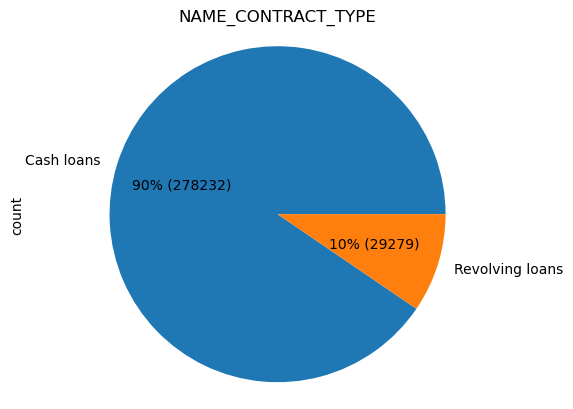

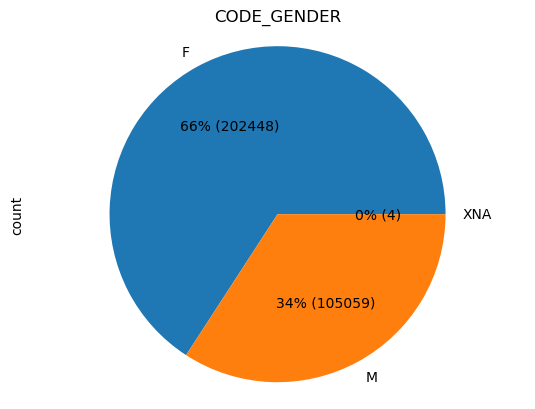

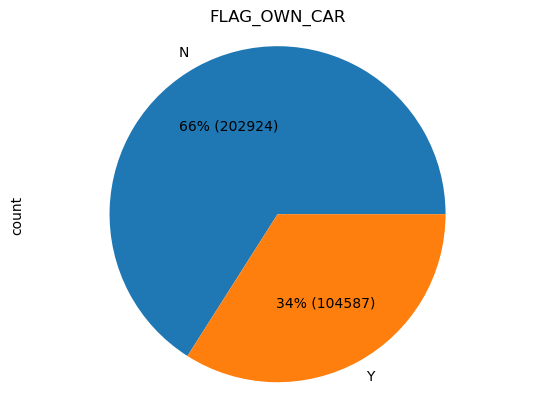

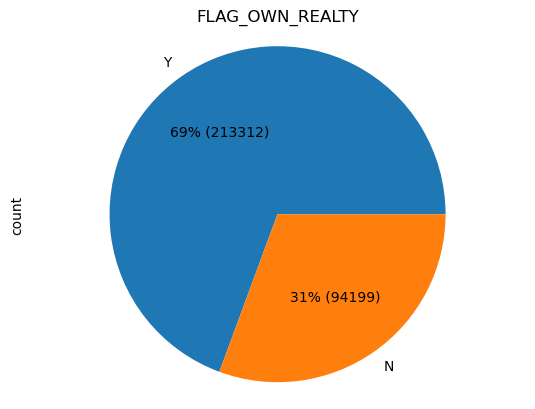

In [7]:
# Sélectionner les variables catégorielles
cat_vars1 = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
cat_vars2 = ['CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


# Générer un pie plot pour chaque variable catégorielle
for var in cat_vars1:
    data_train[var].value_counts().plot(kind='pie', autopct=lambda x: f'{x:.0f}% ({x/100*len(data_train[var]):.0f})')
    plt.title(var)
    plt.axis('equal')
    plt.show()

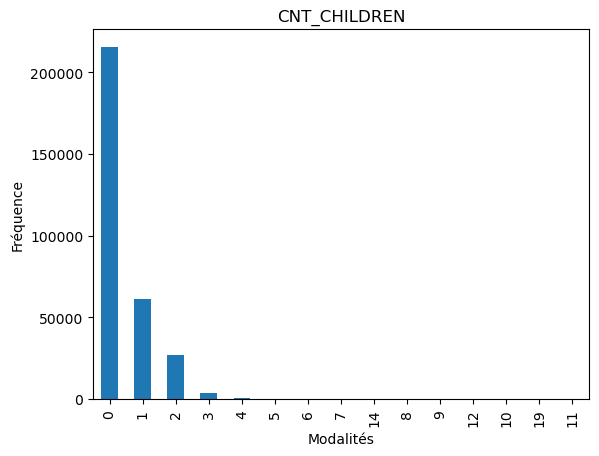

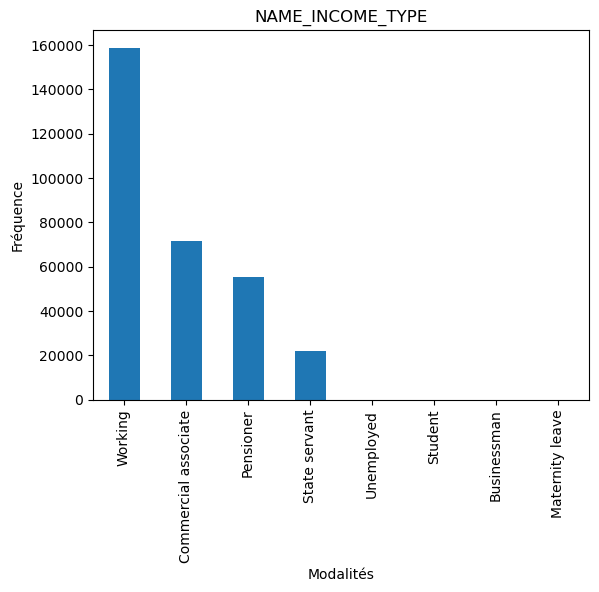

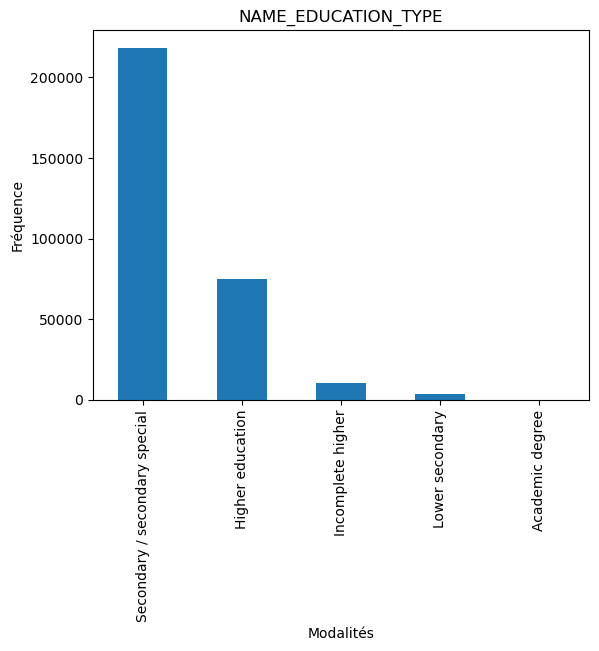

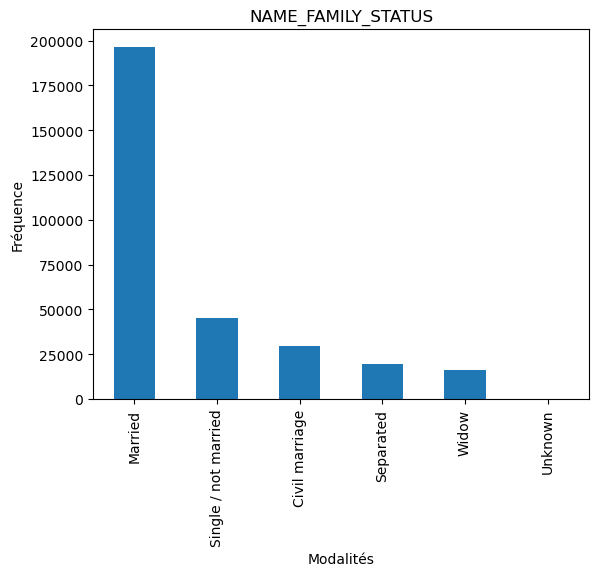

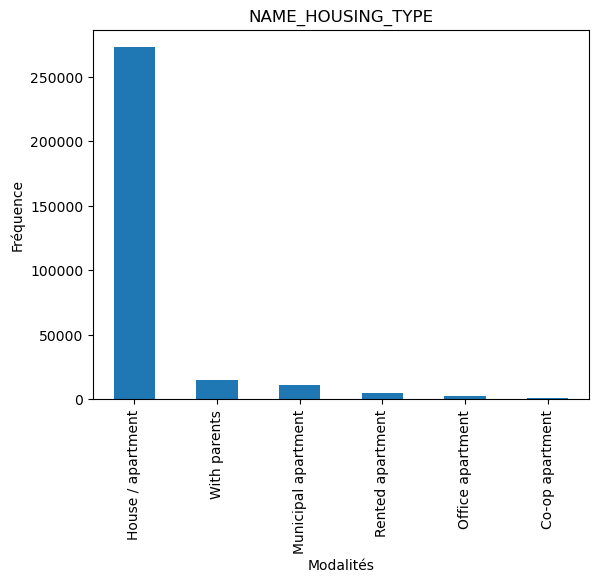

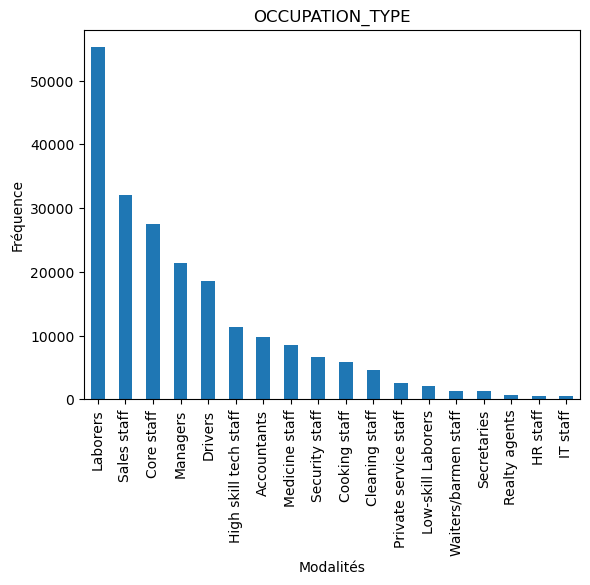

In [8]:
for var in cat_vars2:
    data_train[var].value_counts().plot(kind='bar')
    plt.title(var)
    plt.xlabel('Modalités')
    plt.ylabel('Fréquence')
    plt.show()

In [9]:
# Analyse des valeurs manquantes

# Fonction de calcule des valeurs manquantes par colonne
def missing_values_table(df):
        # Total des valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage des valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Table des résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renommage des colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Trie des valeurs manquantes par pourcentage décroissante
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Visualisation synthétique des résultats
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Retour d'une dataframe avec l'ensemble des valeurs
        return mis_val_table_ren_columns

In [10]:
# Synthèse des valeurs manquantes dans les données d'entraînement
missing_values = missing_values_table(data_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [11]:
# Observons le type des variables

# Nombre de colonne pour chaque type présent
data_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Nous avons 16 variables catégorielles dans les données d'entraînement. Qu'en est-il du nombre de modalité pour chacune de ces varaibles?

In [12]:
# Les modalités pour chaque variable
data_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Il est nécessaire d'encoder ces variables catégorielles afin de les rendre exploitables par l'ensemble des modèles que nous allons construire.
Afin de pas créer trop de variables, les variables ayant au plus 2 modalités seront encodées via Lable encoding et celles ayant plus de 2 modalités seront encodées via 
One-hot encoding en utilisant la fonction get_dummies() de pandas.

In [13]:
data_train['WALLSMATERIAL_MODE'].unique()

array(['Stone, brick', 'Block', nan, 'Panel', 'Mixed', 'Wooden', 'Others', 'Monolithic'], dtype=object)

In [14]:
data_test.dtypes.value_counts()

float64    65
int64      40
object     16
Name: count, dtype: int64

In [15]:
# Les modalités pour chaque variable
data_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
# Alignement des données d'entraînement et de test
'''Afin d'avoir exactement les mêmes variables dans les données d'entraînement et de test, nous devons aligner les deux dataframe train et test tout en conservant 
la variable cible qui n'est pas dans le data_test mais dont nous aurons besoin pour nos analyses'''

train_labels = data_train['TARGET']

# Alignement en ne conservant que les colonnes présentent dans les 2 dataframe
data_train, data_test = data_train.align(data_test, join = 'inner', axis = 1)

# re-introduction de la variable cible
data_train['TARGET'] = train_labels

print('Training Features shape: ', data_train.shape)
print('Testing Features shape: ', data_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [17]:
# Recherche d'anomalies dans les variables

Les chiffres de la colonne DAYS_BIRTH sont négatifs parce qu'ils sont enregistrés par rapport à la demande de prêt en cours. 
Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année.

In [18]:
(data_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [19]:
data_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La valeur maximale ici est de plus de 1000 ans, ceci est absolument incohérent!

Text(0.5, 0, 'Days Employment')

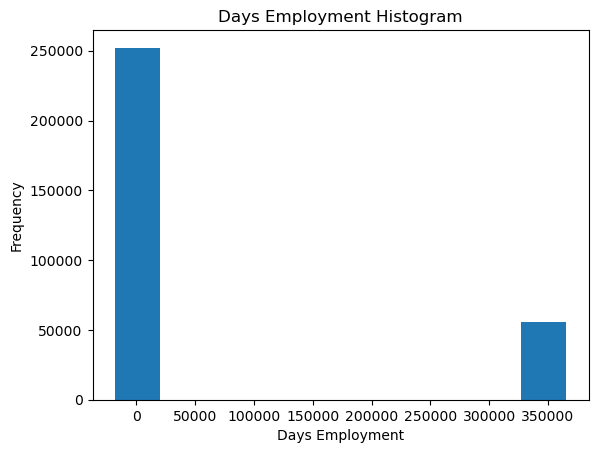

In [20]:
# Analyse de la distribution

data_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [21]:
anom = data_train[data_train['DAYS_EMPLOYED'] == 365243]
non_anom = data_train[data_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Plus de 55000 prêts présentent cette anomalie, remplaçons ces valeurs extrêmes par des valeurs manquantes et analysons à nouveau la distribution.

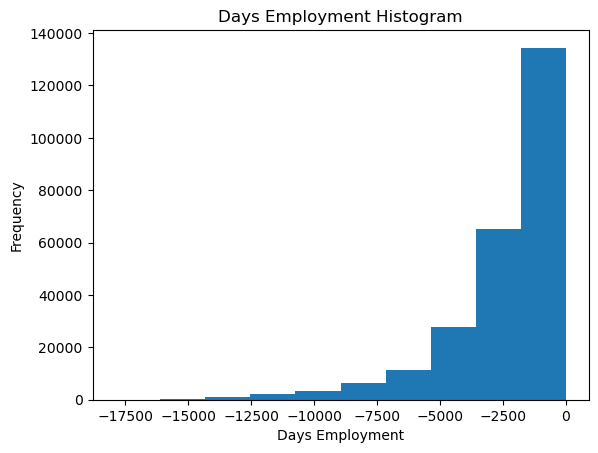

In [22]:
# Creation d'une colonne spécifique pour les valeurs anormales
data_train['DAYS_EMPLOYED_ANOM'] = data_train["DAYS_EMPLOYED"] == 365243

# Replacement des valeurs anormales par des valeurs manquantes
data_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Observons la distribution
data_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');


In [23]:
# Réaliser la même analyse sur les données de test

data_test['DAYS_EMPLOYED_ANOM'] = data_test["DAYS_EMPLOYED"] == 365243
data_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (data_test["DAYS_EMPLOYED_ANOM"].sum(), len(data_test)))

There are 9274 anomalies in the test data out of 48744 entries


## Features engeneering

In [24]:
import gc       # Pour la gestion de l'espace mémoire
import time
from contextlib import contextmanager
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
@contextmanager
def timer(title):       # Pour le calcul du temps de traitement
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [26]:
# One-hot encoding des variables catégorielles avec get_dummies

def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [27]:
# Prétraitement des fichiers application_train.csv et application_test.csv

def application_train_test(num_rows = None, nan_as_category = False):
    
    # Lecture et fusion des données train et test
    df = pd.read_csv('./P7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./P7/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0)
    
    # Nous supprimons les 4 lignes du CODE_GENDER 'XNA' compte tenu des données limitées disponibles sur ce code.
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encodage des variables catégorielles n'ayant que 2 modalités en des variables numériques binaires (0 ou 1)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_CONTRACT_TYPE','EMERGENCYSTATE_MODE']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Application de la fonction d'encodage one_hot_encoder ci-dessus pour les autres variables catégorielles via get_dummies
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Identification des anomalies de la variable DAYS_EMPLOYED ( DAYS_EMPLOYED: 365.243 -> nan)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Création de nouvelles variables (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']               # Pourcentage de jours d'activité du demandeur
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']            # Pourcentage du revenu sur le montant du crédit  
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']        # Revenu par personne dans le foyer
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']          # Pourcentage de l'annuité de remboursement sur le revenu total
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']                       # Taux de remboursement
    
    del test_df
    gc.collect()
    
    return df

In [28]:
# Prétraitement des fichiers bureau.csv et bureau_balance.csv

def bureau_and_balance(num_rows = None, nan_as_category = False):
    
    bureau = pd.read_csv('./P7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./P7/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # bureau_balance: Mise en place des aggrégations et fusion avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # bureau and bureau_balance variables numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # bureau and bureau_balance variables catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # bureau: aggrégations numériques sur les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # bureau: aggrégations numériques sur les crédits non actifs
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [29]:
# Prétraitement du fichier previous_applications.csv

def previous_applications(num_rows = None, nan_as_category = False):
    
    prev = pd.read_csv('./P7/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= False)
    
    # Gestion des anomalies sur les jours ( 365.243 values -> nan)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Création d'une nouvelle variable
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']  # Pourcentage crédit demandé sur crédit obtenu
    
    # Aggrégation sur les variables numériques des précédentes demandes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Variables catégorielles sur les précédentes demandes
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Variables numériques sur les précédentes demandes approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Variables umériques sur les précédentes demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

In [30]:
# Prétraitement su fichier POS_CASH_balance.csv

def pos_cash(num_rows = None, nan_as_category = False):
    
    pos = pd.read_csv('./P7/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # Aggrégation des variables
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Décompte des comptes en cash
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    
    return pos_agg

In [31]:
# Prétraitement du fichier installments_payments.csv

def installments_payments(num_rows = None, nan_as_category = False):
    
    ins = pd.read_csv('./P7/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= False)
    
    # Création de nouvelles variables Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']         # Pourcentage de paiement par rapport au montant de l'échéance due
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']         # Différence de paiement par rapport au montant de l'échéance due
    
    # Création de nouvelles varaibles 
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']          # Nombre de jour de retard de paiment sur l'échéance
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']          # Nombre de jour d'avance de paiement sur l'échéance
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Aggrégation des variables
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Décompte du nombre d'échéance/ versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    
    return ins_agg

In [32]:
# Prétraitement du fichier credit_card_balance.csv

def credit_card_balance(num_rows = None, nan_as_category = False):
    
    cc = pd.read_csv('./P7/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= False)
    
    # Mise en place des aggrégations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Décompte des lignes de crédit accordés par carte  
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    
    return cc_agg

In [33]:
def main(debug = False):
    
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    with timer("Prétraitement bureau et bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        
    with timer("Prétraitement previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        
    with timer("Prétraitement POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        
    with timer("Prétraitement installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        
    with timer("Prétraitement credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        col_to_del = ['BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 
                      'BURO_STATUS_0_MEAN_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'BURO_STATUS_2_MEAN_MEAN', 
                      'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_C_MEAN_MEAN', 'BURO_STATUS_X_MEAN_MEAN', 
                      'ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_MAX_MAX', 
                      'ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'CLOSED_MONTHS_BALANCE_MIN_MIN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
                      'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'REFUSED_APP_CREDIT_PERC_VAR']                                     # Suppression des variables ne contenant que des nan
        
        df = df.drop(col_to_del, axis=1)
        
        df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))              # Changement des titres de certaines colonnes afin de ne garder que des caractères standards
        del cc
        gc.collect()
               
        return df

In [34]:
df = main(debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 112)
Prétraitement bureau et bureau_balance - done in 51s
Previous applications df shape: (338857, 233)
Prétraitement previous_applications - done in 53s
Pos-cash balance df shape: (337252, 18)
Prétraitement POS-CASH balance - done in 31s
Installments payments df shape: (339587, 26)
Prétraitement installments payments - done in 66s
Credit card balance df shape: (103558, 136)
Prétraitement credit card balance - done in 46s


In [35]:
missing_values1 = missing_values_table(df)
missing_values1.head(20)

Your selected dataframe has 754 columns.
There are 576 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.2
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.9
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,284559,79.9
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,284559,79.9
CC_AMT_DRAWINGS_POS_CURRENT_VAR,284559,79.9


In [36]:
# Retrait des colonnes très peu informatives : colonnes qui ont plus de 60% de valeurs manquantes
threshold_value = 60
threshold = ((1-(threshold_value/100))*df.shape[0])
df = df.dropna(axis=1, thresh=threshold)

In [37]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLMpartners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_PRODUCT_COMBINATION_CardXSell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashStreetlow_MEAN,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherswithoutinterest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,

## Partie modélisation

In [38]:
!pip install imblearn
!pip install mlflow
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import shap
import glob

In [39]:
def preprocess_data(df, imputer_method, scaler_method):
    
    # Sélectionner uniquement les caractéristiques numériques
    Target = df.loc[:, ['SK_ID_CURR', 'TARGET']]  # Nous conservons les seules données de la variable cible 'TARGET' dans la data frame Target
    Target = Target.fillna(value='unknown', inplace=False)
    Target.reset_index(drop=True, inplace=True)
    
    numeric_features = df.select_dtypes(include=['int64', 'int32', 'float64']).columns.drop(['SK_ID_CURR', 'TARGET'])
    
    # Choisir la méthode d'imputation
    if imputer_method == 'simple':
        imputer = SimpleImputer(strategy='median')
    elif imputer_method == 'knn':
        imputer = KNNImputer()
    
    # Choisir la méthode de standardisation
    if scaler_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_method == 'robust':
        scaler = RobustScaler()
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', imputer),
        ('scaler', scaler)
    ])
    
    df_processed = numeric_transformer.fit_transform(df[numeric_features])  # Imputation et standardisation selon les méthodes choisies
    df_processed = pd.DataFrame(df_processed, columns=numeric_features)  # Création d'un DataFrame avec les colonnes transformées
    
    # Ajouter les colonnes SK_ID_CURR et TARGET au DataFrame transformé
    df_processed = pd.concat([Target.reset_index(drop=True), df_processed.reset_index(drop=True)], axis=1)                   
    
    # Distinction données d'entraînement et données de test
    train_df = df_processed[df_processed['TARGET']!='unknown']
    test_df = df_processed[df_processed['TARGET']=='unknown']
    train_df['TARGET'] = train_df['TARGET'].astype(int)                            # conversion des observations de la variable cible en entier pour l'utilisation de SMOTE
    del df_processed
    gc.collect()
    
    return train_df, test_df 

In [40]:
train_df, test_df = preprocess_data(df=df, imputer_method='simple', scaler_method='minmax')


In [41]:
print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (307507, 564)
Testing Features shape:  (48744, 564)


In [42]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLMpartners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_PRODUCT_COMBINATION_CardXSell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashStreetlow_MEAN,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherswithoutinterest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,

In [43]:
test_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLMpartners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_PRODUCT_COMBINATION_CardXSell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashStreetlow_MEAN,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithoutinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,PREV_PRODUCT_COMBINATION_POSotherswithoutinterest_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,

In [44]:
# Séparation des Données en Ensembles d'Entraînement et de Test

Seed=876
def split_data(train_df, test_df):
    X = train_df.drop(['TARGET'], axis=1)
    y = train_df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=Seed, stratify=y)
    X_test = test_df.drop(['TARGET'], axis=1)
    return X_train, X_val, y_train, y_val, X_test

In [45]:
X_train, X_val, y_train, y_val, X_test = split_data(train_df, test_df)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (246005, 563)
y_train shape:  (246005,)
X_val shape:  (61502, 563)
y_val shape:  (61502,)
X_test shape:  (48744, 563)


In [49]:
counter = Counter(y_train)
print('répartition des classes avant rééchantillonage :', counter)

répartition des classes avant rééchantillonage : Counter({0: 226145, 1: 19860})


In [50]:
# Application de SMOTE (fait via GridSearchCV pour éviter le data leakage)

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=Seed)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [51]:
X_resampled, y_resampled = apply_smote(X_train, y_train)

  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [52]:
counter = Counter(y_resampled)
print('répartition des classes après rééchantillonage :', counter)

répartition des classes après rééchantillonage : Counter({0: 226145, 1: 226145})


In [54]:
# Sélection des Caractéristiques avec RFE

def feature_selection(X_resampled, y_resampled, X_val, X_test, num_features):
    model = LogisticRegression(random_state=Seed)
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)
    X_val_rfe = rfe.transform(X_val)                     # Application de la transformation RFE aux données de validation
    X_test_rfe = rfe.transform(X_test)                   # Application de la transformation RFE aux données de test
    
    # Créer un DataFrame avec les noms des colonnes sélectionnées
    feature_names = [f for f, s in zip(X_resampled.columns, rfe.support_) if s]
    X_rfe = pd.DataFrame(X_rfe, columns=feature_names)
    X_val_rfe = pd.DataFrame(X_val_rfe, columns=feature_names)
    X_test_rfe = pd.DataFrame(X_test_rfe, columns=feature_names)

    
    return X_rfe, X_val_rfe, X_test_rfe, rfe

In [57]:
X_rfe, X_val_rfe, X_test_rfe, rfe = feature_selection(X_resampled, y_resampled, X_val, X_test, num_features=30)

In [58]:
# Liste des n features retenues
X_rfe.columns.to_list()

['SK_ID_CURR',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_3',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Laborers',
 'ORGANIZATION_TYPE_XNA',
 'HOUSETYPE_MODE_blockofflats',
 'WALLSMATERIAL_MODE_Panel',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'APPROVED_DAYS_DECISION_MIN']

In [54]:
# Entraînement du Modèle de Classification avec GridSearchCV
def train_model(X_rfe, y_resampled, model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy')
    grid_search.fit(X_rfe, y_resampled)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    return best_model, best_params

In [55]:
#best_model, best_params = train_model(X_rfe, y_resampled, model = LogisticRegression(max_iter=1000), param_grid={'C': [0.001, 0.01, 0.1]})

In [56]:
#best_model, best_params

In [57]:
# Évaluation du Modèle avec Métriques Spécifiques et SHAP
def evaluate_model(best_model, X_rfe, y_resampled, X_val_rfe, y_val, X_test_rfe):
    y_pred_val = best_model.predict(X_val_rfe)
    y_pred_proba_val = best_model.predict_proba(X_val_rfe)[:, 1]

    y_pred_train = best_model.predict(X_rfe)
    y_pred_proba_train = best_model.predict_proba(X_rfe)[:, 1]
    
    y_pred_proba_test = best_model.predict_proba(X_test_rfe)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    print("Classification Report:\n", classification_report(y_val, y_pred_val))
    
    # Accuracy Score
    accuracy_val = accuracy_score(y_val, y_pred_val)
    accuracy_train = accuracy_score(y_resampled, y_pred_train)
    print("Accuracy Score (Validation):", accuracy_val)
    print("Accuracy Score (Train):", accuracy_train)
    
    # Recall Score
    recall_val = recall_score(y_val, y_pred_val)
    recall_train = recall_score(y_resampled, y_pred_train)
    print("Recall Score (Validation):", recall_val)
    print("Recall Score (Train):", recall_train)
    
    # ROC AUC Score
    roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)
    roc_auc_train = roc_auc_score(y_resampled, y_pred_proba_train)
    print("ROC AUC Score (Validation):", roc_auc_val)
    print("ROC AUC Score (Train):", roc_auc_train)
    
    # ROC Curve
    fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val)
    fpr_train, tpr_train, _ = roc_curve(y_resampled, y_pred_proba_train)
    
    
    plt.plot(fpr_train, tpr_train, label='ROC curve (Train) (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_val, tpr_val, label='ROC curve (Validation) (area = %0.2f)' % roc_auc_val)
   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calcul du Score Métier
    FP = cm[0, 1]
    FN = cm[1, 0]
    score_metier = FP + 10 * FN
    print("Score Métier:", score_metier)
    
    return accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier, y_pred_proba_test

In [58]:
#accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier, y_pred_proba_test = evaluate_model(best_model, X_rfe, y_resampled, X_val_rfe, y_val, X_test_rfe)

In [59]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")


In [59]:
def full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid):
    
    experiment_name = f"{imputer_method}_{scaler_method}_{num_features}_{model.__class__.__name__}"
    
    mlflow.set_experiment("class_scoring_experiment")
    
    with mlflow.start_run(run_name=experiment_name):
        # Log parameters
        mlflow.log_param("imputer_method", imputer_method)
        mlflow.log_param("scaler_method", scaler_method)
        mlflow.log_param("num_features", num_features)
        mlflow.log_param("model", model.__class__.__name__)
        mlflow.log_param("param_grid", str(param_grid))
        
        # Recovery of aggregated and encoded data from various sources
        df = main(debug=debug)
        
        # Preprocess data
        train_df, test_df = preprocess_data(df, imputer_method, scaler_method)
        
        # Split data
        X_train, X_val, y_train, y_val, X_test = split_data(train_df, test_df)
        
        # Apply SMOTE
        X_resampled, y_resampled = apply_smote(X_train, y_train)
        
        # Feature selection
        X_rfe, X_val_rfe, X_test_rfe, rfe = feature_selection(X_resampled, y_resampled, X_val, X_test, num_features)
    
        # Train model
        best_model, best_params = train_model(X_rfe, y_resampled, model, param_grid)
        mlflow.log_params(best_params)
        
        # Evaluate model
        accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier, y_pred_proba_test = evaluate_model(best_model, X_rfe, y_resampled, X_val_rfe, y_val, X_test_rfe)

        # Log metrics
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("roc_auc_train", roc_auc_train)
        mlflow.log_metric("roc_auc_val", roc_auc_val)
        mlflow.log_metric("score_metier", score_metier)
             
        # Log model
        mlflow.sklearn.log_model(best_model, "model")

        # End the run
        mlflow.end_run()
    
    return best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s


  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Confusion Matrix:
 [[1336  509]
 [  68   87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.72      0.82      1845
           1       0.15      0.56      0.23       155

    accuracy                           0.71      2000
   macro avg       0.55      0.64      0.53      2000
weighted avg       0.89      0.71      0.78      2000

Accuracy Score (Validation): 0.7115
Accuracy Score (Train): 0.737059620596206
Recall Score (Validation): 0.5612903225806452
Recall Score (Train): 0.7506775067750677
ROC AUC Score (Validation): 0.7086948159804178
ROC AUC Score (Train): 0.8063112234780885


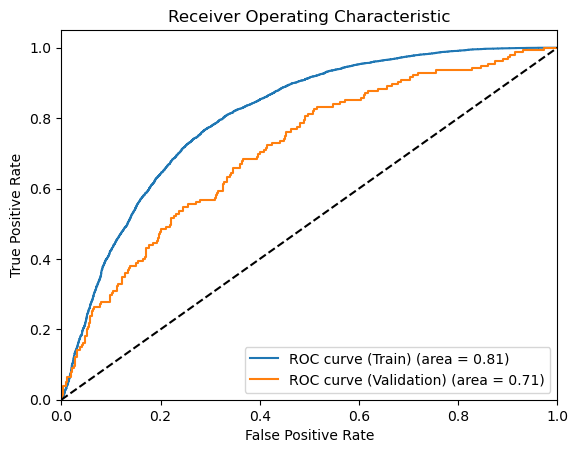

Score Métier: 1189


In [47]:
debug = True
imputer_method = 'knn'
scaler_method = 'minmax'
num_features = 50
model = LogisticRegression(random_state=Seed)
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10]}


best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s
Confusion Matrix:
 [[1340  505]
 [  72   83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.82      1845
           1       0.14      0.54      0.22       155

    accuracy                           0.71      2000
   macro avg       0.55      0.63      0.52      2000
weighted avg       0.89      0.71      0.78      2000

Accuracy Score (Validation): 0.7115
Accuracy Score (Train): 0.7428184281842819
Recall Score (Validation): 0.535483870967742


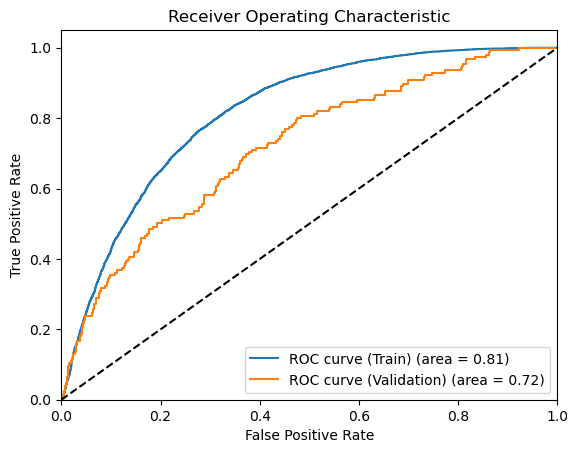

Score Métier: 1225


In [48]:
debug = True
imputer_method = 'knn'
scaler_method = 'robust'
num_features = 50
model = LogisticRegression(random_state=Seed)
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10]}


best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s
Confusion Matrix:
 [[1698  147]
 [ 126   29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1845
           1       0.16      0.19      0.18       155

    accuracy                           0.86      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.87      0.86      0.87      2000

Accuracy Score (Validation): 0.8635
Accuracy Score (Train): 0.9984417344173442
Recall Score (Validation): 0.1870967741935484

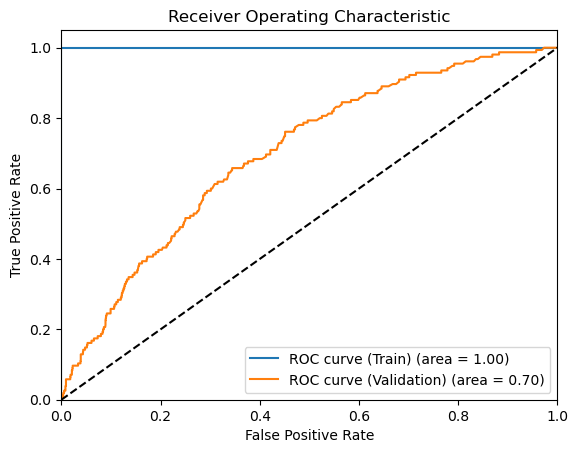

Score Métier: 1407


In [49]:
# Deuxième run

debug = True
imputer_method = 'simple'
scaler_method = 'minmax'
num_features = 50
model = RandomForestClassifier(random_state=Seed)
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 7]}

best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5904, number of negative: 5904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

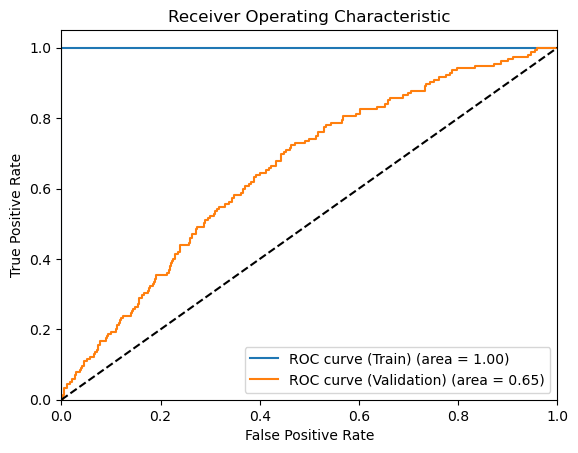

Score Métier: 1472


In [50]:
# Troisième run

debug = True
imputer_method = 'simple'
scaler_method = 'minmax'
num_features = 50
model = LGBMClassifier(random_state=Seed)
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.01, 0.1, 0.5]}

best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

In [51]:
best_model

LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=300,
               random_state=876)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s
[LightGBM] [Info] Number of positive: 5904, number of negative: 5904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 11808, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Nu

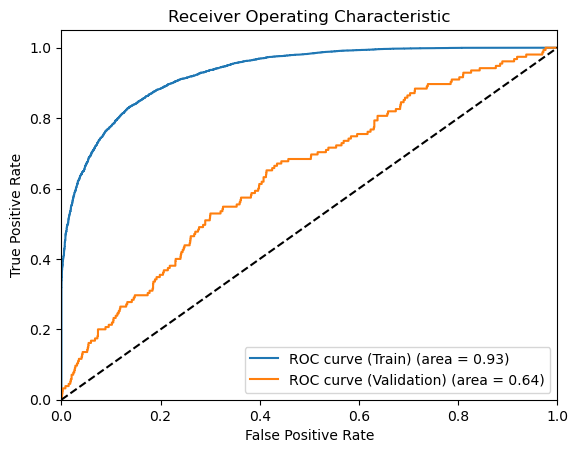

Score Métier: 1402


In [55]:
debug = True
imputer_method = 'simple'
scaler_method = 'minmax'
num_features = 20
model = LGBMClassifier(random_state=Seed)
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [-1, 10], 'learning_rate': [0.01, 0.02, 0.03]}

best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

In [56]:
best_model

LGBMClassifier(learning_rate=0.03, n_estimators=300, random_state=876)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 104)
Prétraitement bureau et bureau_balance - done in 1s
Previous applications df shape: (9734, 226)
Prétraitement previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Prétraitement POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Prétraitement installments payments - done in 1s
Credit card balance df shape: (9520, 126)
Prétraitement credit card balance - done in 1s


  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Confusion Matrix:
 [[1519  326]
 [ 107   48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.88      1845
           1       0.13      0.31      0.18       155

    accuracy                           0.78      2000
   macro avg       0.53      0.57      0.53      2000
weighted avg       0.87      0.78      0.82      2000

Accuracy Score (Validation): 0.7835
Accuracy Score (Train): 0.9147018970189702
Recall Score (Validation): 0.3096774193548387
Recall Score (Train): 0.9117886178861788
ROC AUC Score (Validation): 0.6242293906810036
ROC AUC Score (Train): 0.9756121888793414


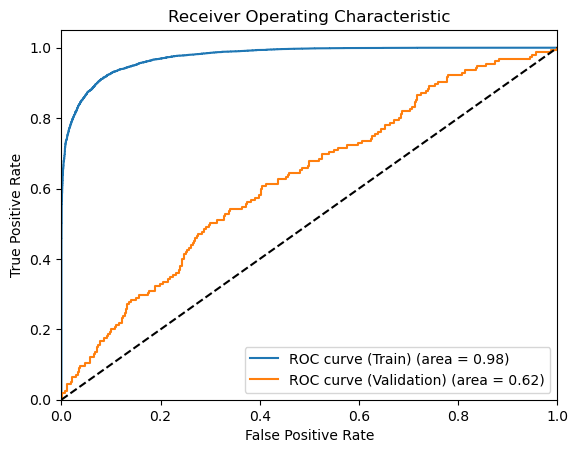

Score Métier: 1396


In [60]:
debug = True
imputer_method = 'simple'
scaler_method = 'minmax'
num_features = 20
model = GradientBoostingClassifier(random_state=Seed)
param_grid = {'learning_rate': [0.1, 0.2, 0.3],'max_depth': [3, 4, 5], 'min_samples_leaf': [30, 31, 32], 'n_estimators': [100, 200, 300]}

best_model, accuracy_train, accuracy_val, recall_train, recall_val, roc_auc_train, roc_auc_val, score_metier = full_pipeline(debug, imputer_method, scaler_method, num_features, model, param_grid)

In [61]:
best_model

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_leaf=31,
                           n_estimators=300, random_state=876)

In [ ]:
 # Importance des Caractéristiques avec SHAP
    explainer = shap.Explainer(best_model, X_rfe)
    shap_values = explainer(X_val_rfe)

    # Graphiques SHAP globaux
    shap.summary_plot(shap_values, X_val_rfe, plot_type="bar", feature_names=X_rfe.columns)
    shap.summary_plot(shap_values, X_val_rfe, feature_names=X_rfe.columns)
    
    # Graphiques SHAP locaux pour quelques exemples
    i = 0
    shap.plots.waterfall(shap_values[i])